<a href="https://colab.research.google.com/github/zkaganz/Duygu-Analizi/blob/main/text_to_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # regex to detect username, url, html entity
import nltk # to use word tokenize (split the sentence into words)
from nltk.corpus import stopwords # to remove the stopwords
from sklearn.model_selection import train_test_split
nltk.download("stopwords")
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from keras.utils import to_categorical
from keras import backend as K

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/deneme/text-emotions/text.csv")
data.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
data.drop("Unnamed: 0",axis=1,inplace=True)
data.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
#emotion_mp = { 0: "uzuntu" , 1:"eglenceli" , 2: "ask" ,3: "sinirli" ,4: "korkmus" , 5: "sasırmıs"}
#data["label"] = data["label"].map(emotion_mp)

In [ ]:
#data.head()

<Axes: xlabel='label', ylabel='Count'>

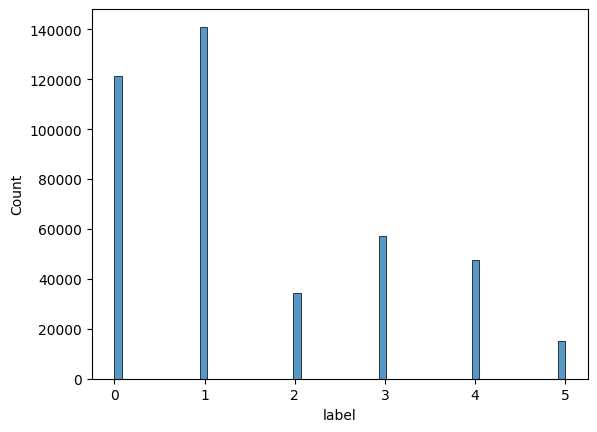

In [ ]:
sns.histplot(data["label"],kde=False)

In [ ]:
text = list(data['text'])
labels = list(data['label'])

In [ ]:
sample_rev  = data.text[0] # 0. datamızın ham hali
sample_rev

'i just feel really helpless and heavy hearted'

In [ ]:
def process(text) :
  soup = BeautifulSoup(text, 'html.parser')
  text_text = soup.get_text()
  text = re.sub("[^a-zA-Z]"," ", text)
  text = text.lower()
  text = text.split()
  stopw = set(stopwords.words("english"))
  text = [w for w in text if w not in stopw]
  return " ".join(text)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42)

In [ ]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
max_length = max(len(seq) for seq in X_train)


for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

In [ ]:
y_test = to_categorical(y_test, num_classes=6)
y_train = to_categorical(y_train, num_classes=6)

In [ ]:
print(f"num test text: {y_test.shape[0]}")
print(f"num train text: {y_train.shape[0]}")

num test text: 83362
num train text: 333447


In [ ]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [ ]:
output_dim = 200

# LSTM model architechture (CNN + LSTM)
model = Sequential([
    # embedding layer is like idk
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 6 class (0, 1, 2, 3, 4, 5)
    Dense(6, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 178, 200)          13590000  
                                                                 
 lstm (LSTM)                 (None, 64)                67840     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 13666934 (52.14 MB)
Trainable params: 1366

In [ ]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=5,
    validation_data=(X_test, y_test)
)

Epoch 1/5
5211/5211 [==============================] - 4653s 892ms/step - loss: 0.2630 - accuracy: 0.8895 - f1: 0.8783 - precision: 0.9109 - recall: 0.8590 - val_loss: 0.0981 - val_accuracy: 0.9377 - val_f1: 0.9382 - val_precision: 0.9439 - val_recall: 0.9327
Epoch 2/5
5211/5211 [==============================] - 4568s 877ms/step - loss: 0.1057 - accuracy: 0.9380 - f1: 0.9384 - precision: 0.9456 - recall: 0.9314 - val_loss: 0.0942 - val_accuracy: 0.9396 - val_f1: 0.9400 - val_precision: 0.9440 - val_recall: 0.9360
Epoch 3/5
5211/5211 [==============================] - 4590s 881ms/step - loss: 0.0974 - accuracy: 0.9402 - f1: 0.9403 - precision: 0.9453 - recall: 0.9354 - val_loss: 0.0925 - val_accuracy: 0.9409 - val_f1: 0.9411 - val_precision: 0.9441 - val_recall: 0.9381
Epoch 4/5
5211/5211 [==============================] - 4540s 871ms/step - loss: 0.0936 - accuracy: 0.9413 - f1: 0.9415 - precision: 0.9455 - recall: 0.9376 - val_loss: 0.0921 - val_accuracy: 0.9404 - val_f1: 0.9408 - val

In [ ]:
print("Accuracy: ", model.evaluate(X_test, y_test)[1])

2606/2606 [==============================] - 153s 59ms/step - loss: 0.0933 - accuracy: 0.9409 - f1: 0.9410 - precision: 0.9425 - recall: 0.9396
Accuracy:  0.9409443140029907


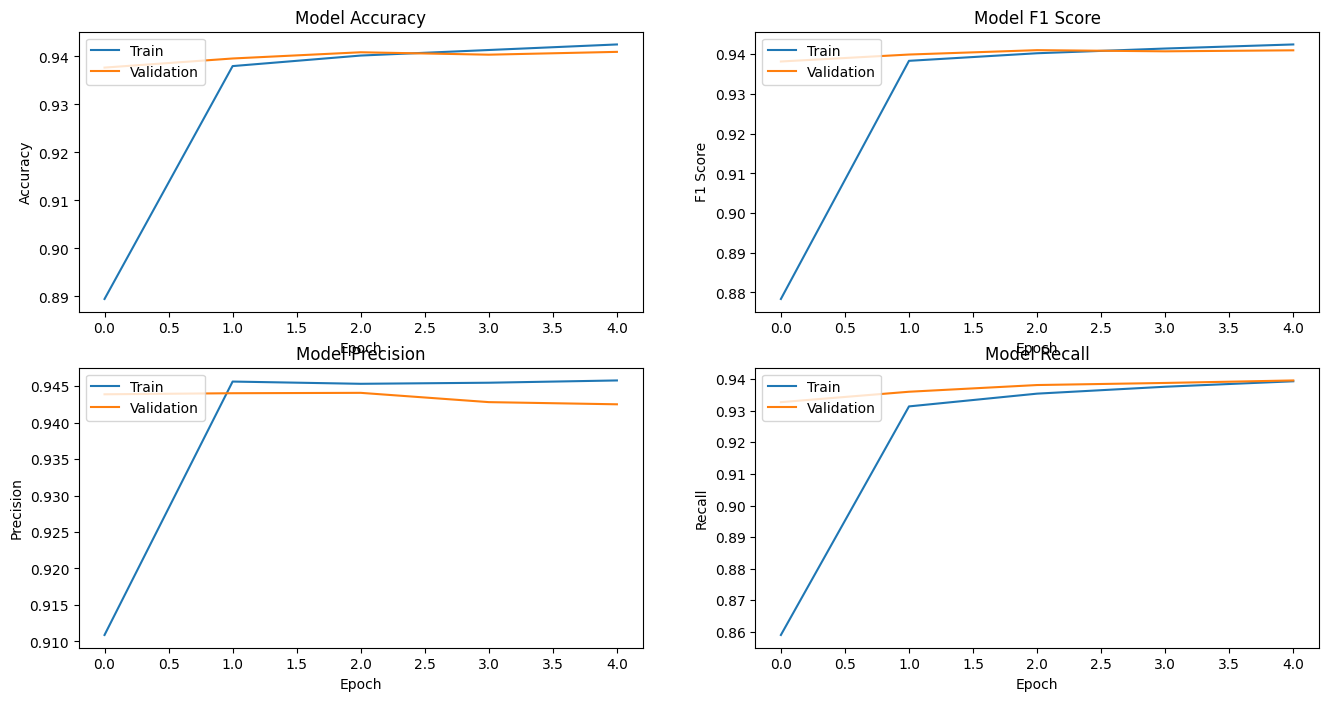

In [ ]:
# prompt: bana  accuracy , f1 , precision ,  recall değerlerini grafikte gösteren kodu ver

import matplotlib.pyplot as plt
# Get the metrics from the model history
metrics = model_history.history

# Create a figure with 4 subplots
plt.figure(figsize=(16, 8))

# Subplot 1: Accuracy
plt.subplot(2, 2, 1)
plt.plot(metrics['accuracy'])
plt.plot(metrics['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Subplot 2: F1 Score
plt.subplot(2, 2, 2)
plt.plot(metrics['f1'])
plt.plot(metrics['val_f1'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Subplot 3: Precision
plt.subplot(2, 2, 3)
plt.plot(metrics['precision'])
plt.plot(metrics['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Subplot 4: Recall
plt.subplot(2, 2, 4)
plt.plot(metrics['recall'])
plt.plot(metrics['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plot
plt.show()


In [ ]:
sample_text = "i want to get away from everything because I'm so sad"
sample_text = process(sample_text)
sample_text = [sample_text]
sample_text = tokenizer.texts_to_sequences(sample_text)
sample_text = pad_sequences(sample_text, maxlen = max_length)
prediction = model.predict(sample_text)
predicted_label = np.argmax(prediction)
emotion_mp = { 0: "üzüntü" , 1:"neşe" , 2: "sevgi" ,3: "sinirli" ,4: "korkmuş" , 5: "şaşırmış"}
print(f"Predicted emotion: {emotion_mp[predicted_label]}")

1/1 [==============================] - 0s 82ms/step
Predicted emotion: üzüntü
